In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? Y


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import julian
from collections import defaultdict
#import datetime
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import linregress, kendalltau, spearmanr, pearsonr
import pickle

# EM-DAT data

In [3]:
# Load and format EM-DAT data
data = pd.read_excel(r'/home/jbaldwin/WorldBank/ASSET_LOSSES/emdat_2021_02_10_philippines_TCs.xlsx', skiprows=6)

df = pd.DataFrame(data, columns= ['Event Name','Start Year','Start Month', 'Start Day', 'End Year','End Month', 'End Day', "Total Damages ('000 US$)"])
df = df[~np.isnan(df["Total Damages ('000 US$)"])] # select only data with damages

total_damages = np.array(df["Total Damages ('000 US$)"])*1000 # factor in the 1000 here so can ignore


# Dates only for data with damages
# Start and end dates
start_year = df['Start Year'].values*10000
start_month = df['Start Month'].values*100
start_day = df['Start Day'].values
start_date = (start_year+start_month+start_day).astype('int')
start_date = pd.to_datetime(start_date.astype(str),errors='coerce').values
# Start Date with only Year-Month because some day values missing
start_date_yearmonth = (start_year+start_month+1).astype('int')
start_date_yearmonth = pd.to_datetime(start_date_yearmonth.astype(str),errors='coerce').values

end_year = df['End Year'].values*10000
end_month = df['End Month'].values*100
end_day = df['End Day'].values
end_date = (end_year+end_month+end_day).astype('int')
end_date = pd.to_datetime(end_date.astype(str),errors='coerce').values
# End Date with only Year-Month because some day values missing
end_date_yearmonth = (end_year+end_month+1).astype('int')
end_date_yearmonth = pd.to_datetime(end_date_yearmonth.astype(str),errors='coerce').values

Text(0, 0.5, '# of Events')

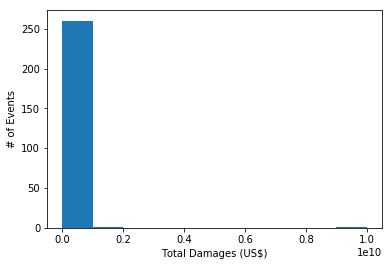

In [4]:
# Plot histogram of Philippines TC damages
plt.hist(total_damages)
plt.xlabel("Total Damages (US$)")
plt.ylabel('# of Events')

Text(0.5, 1.0, 'Philippines TCs in EM-DAT')

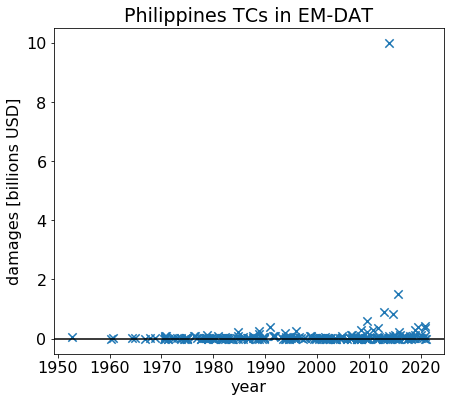

In [5]:
# Plot time series of Philippines TC damages
plt.figure(figsize=(7, 6))
plt.rcParams.update({'font.size': 16})
ax = plt.subplot(111)
plt.scatter(start_date_yearmonth,total_damages/1e9, marker = 'x', s=70)
#ax.set_yscale('log')
#plt.xlim([np.min(start_date_yearmonth),np.max(start_date_yearmonth)])
plt.xlabel('year')
plt.ylabel('damages [billions USD]')
plt.axhline(0,color='k')
plt.title('Philippines TCs in EM-DAT')
#plt.ylim([0,0.1e9])

# Modeled damage data

In [6]:
# Data files
direc = '/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI'
file_swaths = '/SWATHS/wspd_phi_swaths_maxasymcorrec_ibtracsv04r00_3-8-21.nc'
file_damages = '/ASSET_LOSSES/VCURVE_SENSITIVITY/phi_assetlosses_Vhalf-84.7_Vthresh-25.7.nc'

# Get dates from damage data
ds_damages = xr.open_dataset(direc + file_damages)
nmax = len(ds_damages.nS)
tc_start_date = ds_damages.start_date.values
tc_end_date = ds_damages.end_date.values
year = np.zeros(len(tc_start_date))
for i in range(len(tc_start_date)):
    year[i] = int(str(tc_start_date[i])[0:4])

#%%time
# Match all with exact date match (Y-m-d)
nemax = len(start_date)
match = np.zeros((nemax,nmax))
for ne in range(nemax):
    if start_date[ne] == np.datetime64('NaT'):
        pass # skip if don't have day value
    else:
        emdat_range = pd.period_range(start_date[ne],end_date[ne])
        for nt in range(nmax):
            tc_range = pd.period_range(tc_start_date[nt],tc_end_date[nt])
            match[ne,nt] = sum(np.isin(tc_range,emdat_range)) # count number of days of overlap


# Select pairs where have greatest number of matches

# Value of greatest overlap
ne_max = np.max(match,axis=1)
ne_max_i = []
nt_max = np.max(match,axis=0)
nt_max_i = []


# Indices of place with greatest overlap
for ne in range(nemax):
    if ne_max[ne] == 0:
        pass
    else:
        ne_max_i.append([ne,np.where(match[ne,:] == ne_max[ne])[0]])
for nt in range(nmax):
    if nt_max[nt] == 0:
        pass
    else:
        nt_max_i.append([nt,np.where(match[:,nt] == nt_max[nt])[0]])

# Divide between clear match and ambiguous (multiple possible matches)
nt_max_i_clear = []
nt_max_i_ambi = []
for nn in range(len(nt_max_i)):
    if len(nt_max_i[nn][1]) == 1:
        nt_max_i_clear.append(np.array([nt_max_i[nn][1][0],nt_max_i[nn][0]]))
    else:
        nt_max_i_ambi.append(nt_max_i[nn]) 
        
ne_max_i_clear = []
ne_max_i_ambi = []
for nn in range(len(ne_max_i)):
    if len(ne_max_i[nn][1]) == 1:
        ne_max_i_clear.append(np.array([ne_max_i[nn][0],ne_max_i[nn][1][0]]))
    else:
        ne_max_i_ambi.append(ne_max_i[nn]) 

# Indices where 1 clear match
ne_pairs = np.stack(ne_max_i_clear,axis=0)
nt_pairs = np.stack(nt_max_i_clear,axis=0)
def intersect2D(a, b):
  """
  Find row intersection between 2D numpy arrays, a and b.
  Returns another numpy array with shared rows
  """
  return np.array([x for x in set(tuple(x) for x in a) & set(tuple(x) for x in b)])
matches = intersect2D(ne_pairs,nt_pairs) # emdat index, tc index

/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: In the future, 'NAT == x' and 'x == NAT' will always be False.


In [10]:
# # Format TC days from MJD to Numpy datetime objects
# ds_swaths = xr.open_dataset(direc + file_swaths)

# # Convert modified Julian days to date-time objects
# nmax = len(ds_swaths.nS)
# imax = len(ds_swaths.iT)
# dt = np.full([nmax, imax], np.nan, dtype='datetime64[s]')
# month = np.full([nmax, imax], np.nan)
# day = np.full([nmax, imax], np.nan)
# for n in range(nmax):
#     mjd = ds_swaths.days[n,:]
#     for i in np.where(~np.isnan(mjd))[0]:
#         x = julian.from_jd(mjd[i], fmt='mjd').date()
#         dt[n][i] = x
#         month[n,i] = int(x.month)
#         day[n,i] = int(x.day)
# year = ds_swaths.year.values


# # Calculate TC start and end dates
# tc_start_date = np.min(dt,axis=1)
# tc_end_date = np.max(dt,axis=1)


## Ones to potentially double check and do more work on: 
* Indices where more than 1 match
* Events with Y-m but not d

# Normalize losses by total capital stock

In [7]:
# LitPop is for 2014
pwt_data = pd.read_excel(r'/home/jbaldwin/WorldBank/ASSET_LOSSES/pwt100.xlsx', sheet_name = 2)
pwt_df = pd.DataFrame(pwt_data, columns= ['country','countrycode','currency_unit','year','rnna','rgdpna'])
pwt_df = pwt_df[pwt_df['country']=='Philippines'] # subset just data for Philippines
pwt_df['rnna'] = pwt_df['rnna']*1e6
pwt_df['rgdpna'] = pwt_df['rgdpna']*1e6

# Normalize EM-DAT damages to 2014 assets
total_damages_norm = np.full(np.shape(total_damages),np.nan)
baserate = pwt_df['rnna'][pwt_df['year']==2014].values[0]
for i in range(len(total_damages)):
    try:
        yearrate = pwt_df['rnna'][pwt_df['year']==start_year[i]/10000].values[0]
        total_damages_norm[i] = total_damages[i]*baserate/yearrate
    except:
        pass

# For 2020 storms normalize by 2019, because PWT stops at 2019
for i in np.where(start_year/10000 == 2020):
    yearrate = pwt_df['rnna'][pwt_df['year']==2019].values[0]
    total_damages_norm[i] = total_damages[i]*baserate/yearrate

Text(0, 0.5, 'Philippines GDP\nat 2017 National Prices [USD]')

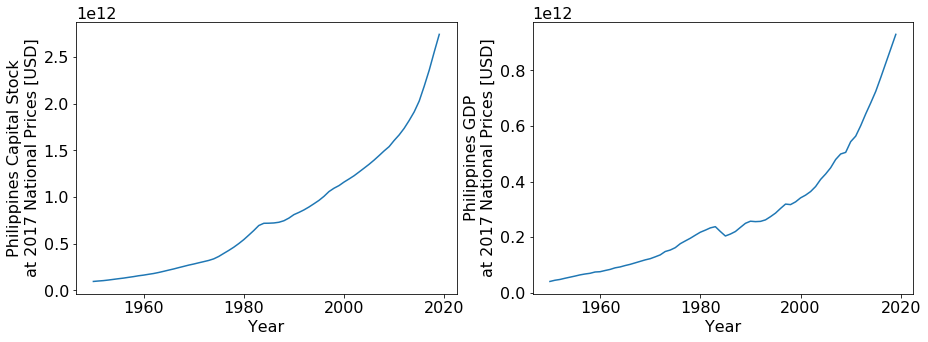

In [8]:
# Plot capital stock vs GDP changes through time Philippines
plt.figure(figsize=(15, 5))
plt.subplot(121)
pwt_phi = pwt_df[pwt_df['country']=='Philippines']
plt.plot(pwt_df['year'],pwt_df['rnna'])
plt.xlabel('Year')
plt.ylabel('Philippines Capital Stock\nat 2017 National Prices [USD]')

plt.subplot(122)
pwt_phi = pwt_df[pwt_df['country']=='Philippines']
plt.plot(pwt_df['year'],pwt_df['rgdpna'])
plt.xlabel('Year')
plt.ylabel('Philippines GDP\nat 2017 National Prices [USD]')


(0, 2000000000.0)

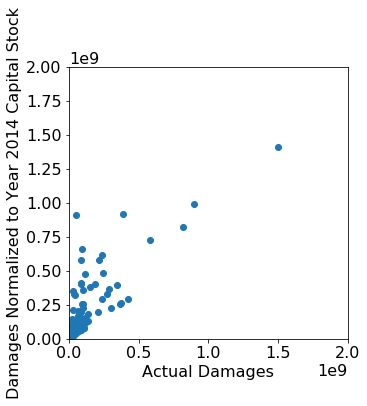

In [9]:
plt.figure(figsize=(5, 5))
plt.scatter(total_damages,total_damages_norm)
plt.xlabel('Actual Damages')
plt.ylabel('Damages Normalized to Year 2014 Capital Stock')
plt.xlim([0,0.2e10])
plt.ylim([0,0.2e10])

Text(0, 0.5, '# of Events')

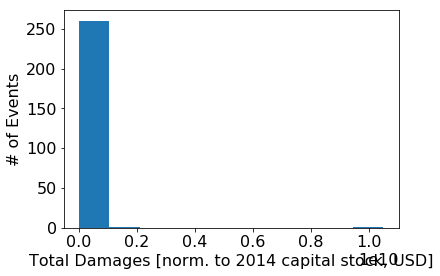

In [10]:
# Plot histogram of normalized Philippines TC damages
plt.hist(total_damages_norm)
plt.xlabel("Total Damages [norm. to 2014 capital stock, USD]")
plt.ylabel('# of Events')

(-0.5, 11)

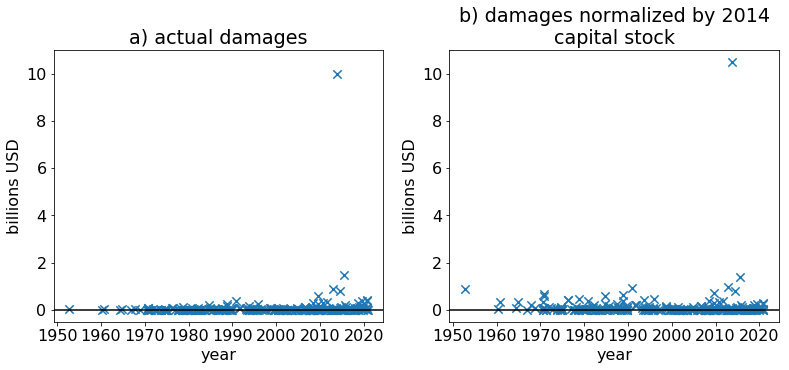

In [11]:
# Plot time series of Philippines TC damages
plt.figure(figsize=(13, 5))
plt.rcParams.update({'font.size': 16})
ax = plt.subplot(121)
plt.scatter(start_date_yearmonth,total_damages/1e9, marker = 'x', s=70)
#ax.set_yscale('log')
#plt.xlim([np.min(start_date_yearmonth),np.max(start_date_yearmonth)])
plt.xlabel('year')
plt.ylabel('billions USD')
plt.axhline(0,color='k')
plt.title('a) actual damages')
plt.ylim([-0.5,11])

ax = plt.subplot(122)
plt.scatter(start_date_yearmonth,total_damages_norm/1e9, marker = 'x', s=70)
#ax.set_yscale('log')
#plt.xlim([np.min(start_date_yearmonth),np.max(start_date_yearmonth)])
plt.xlabel('year')
plt.ylabel('billions USD')
plt.axhline(0,color='k')
plt.title('b) damages normalized by 2014\ncapital stock')
plt.ylim([-0.5,11])

/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


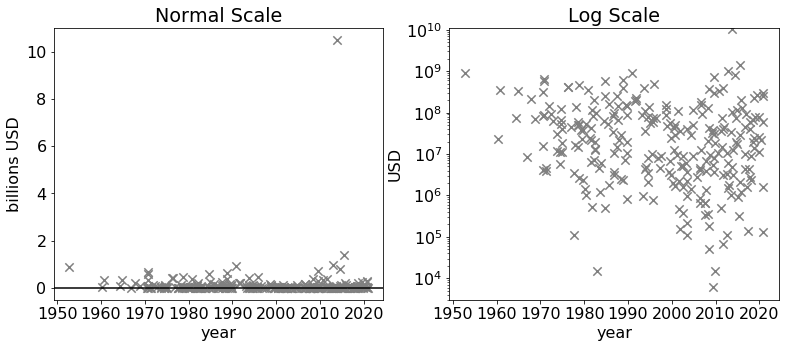

In [40]:
# Plot time series of Philippines TC damages normalized by 2014 capital stock
plt.figure(figsize=(13, 5))
plt.rcParams.update({'font.size': 16})
ax = plt.subplot(121)
plt.scatter(start_date_yearmonth,total_damages_norm/1e9, marker = 'x', s=70,color='grey')
#ax.set_yscale('log')
#plt.xlim([np.min(start_date_yearmonth),np.max(start_date_yearmonth)])
plt.xlabel('year')
plt.ylabel('billions USD')
plt.axhline(0,color='k')
plt.title('Normal Scale')
plt.ylim([-0.5,11])

ax = plt.subplot(122)
plt.scatter(start_date_yearmonth,total_damages_norm, marker = 'x', s=70,color='grey')
ax.set_yscale('log')
#plt.xlim([np.min(start_date_yearmonth),np.max(start_date_yearmonth)])
plt.xlabel('year')
plt.ylabel('USD')
plt.axhline(0,color='k')
plt.title('Log Scale')
plt.ylim([-0.5e9,11e9])
plt.savefig('FIGURES/obsdamages_timeseries.png',dpi=400)

# Plot comparing asset losses from TCs vs known damages

In [13]:
# Load Philippines province masks

d_mask = xr.open_dataset('/home/jbaldwin/WorldBank/REGION_MASKS/philippines_province_masks_newlitpopgrid.nc')
d_mask_wind = xr.open_dataset('/home/jbaldwin/WorldBank/REGION_MASKS/philippines_province_masks_windfield.nc')

pickle_in = open("/home/jbaldwin/WorldBank/REGION_MASKS/state_ids.p","rb")
state_ids = pickle.load(pickle_in)


In [14]:
# FUNCTIONS FOR CORRELATION METRICS
def TDR(mod,obs): # inputs are paired modeled and observed losses
    tdr = np.sum(mod)/np.sum(obs) # total damage ratio-- closest to 1 is optimal
    return tdr

def RMSF(mod,obs): # inputs are paired modeled and observed losses
    edr = mod/obs # event damage ratio
    edr_no0 = edr[np.where(edr>0)] # exclude 0 points because can't calculate log for those
    rmsf = np.exp((np.mean(np.log(edr_no0)**2))**0.5) # root-mean squared fraction-- lower = better fit
    return rmsf, edr

def corr_metrics(mod,obs):
    pr = pearsonr(mod, obs)[0]
    ktau = kendalltau(mod, obs)[0]
    sr = spearmanr(mod, obs)[0]
    tdr = TDR(mod, obs)
    rmsf, edr = RMSF(mod, obs)
    return pr, ktau, sr, tdr, rmsf, edr

def corr_metrics2(mod,obs):
    tdr = TDR(mod, obs)
    rmsf, edr = RMSF(mod, obs)
    return tdr, rmsf

In [15]:
# Determine if positive wind speed in Manila
ds_swaths = xr.open_dataset(direc+file_swaths)
wind_reg = {}
affected_wind = {}
for key in ['NCR']:
            mask0 = d_mask_wind.states.where(d_mask_wind.states==state_ids[key])
            mask0 = mask0/mask0
            mask = np.repeat(np.expand_dims(mask0,axis=0), np.shape(ds_swaths.swath)[0], axis=0)
            wind_reg[key] = (ds_swaths.swath*mask).max(dim=['lat','lon']).values
            affected_wind[key] = np.where(wind_reg[key]>0)

In [16]:
#%%time
# Plot comparing simulated damages to observed damages
Vthresh = np.arange(15,40,5)# Eberenz et al 2020, 25.7 is value used for all and 10 below and above that; m/s
Vhalf = np.arange(50,210,10)# Eberenz et al 2020, value for Philippines using default, RMSF calculation, and TDR calculation; m/s

obs_paired_losses = {}
mod_paired_losses = {}
modeled_damages = {}
obs_paired_losses_ncr = {}
mod_paired_losses_ncr = {}
modeled_damages_ncr = {}
obs_paired_losses_noncr = {}
mod_paired_losses_noncr = {}
modeled_damages_noncr = {}
est_cost_reg = {}
year_ncr = {}
year_noncr = {}
affected_assets = {}
affected_assets_match = {}
no_affected_assets = {}
no_affected_assets_match = {}
pr = defaultdict(dict)
ktau = defaultdict(dict)
sr = defaultdict(dict)
tdr = defaultdict(dict)
rmsf = defaultdict(dict)
edr = defaultdict(dict)

for vt in Vthresh:
    for vh in Vhalf:
        
        # Calculate modeled damages
        label = 'Vhalf-'+str(vh)+'_Vthresh-'+str(vt)
        file_damages = '/ASSET_LOSSES/VCURVE_SENSITIVITY/'+label+'.nc'
        ds_damages = xr.open_dataset(direc + file_damages)
        modeled_damages[label] = ds_damages.sum(dim=['lon','lat']).asset_losses.values

        # Pair observed and modeled damages
        obs_paired_losses[label] = total_damages_norm[matches[:,0]]
        mod_paired_losses[label] = modeled_damages[label][matches[:,1]]

        # Select storms that have positive asset losses in NCR 
        # Note: could also just select ones that have positive windspeed, which is what Eberenz does
        est_cost_reg = {}
        for key in ['NCR']:
            mask0 = d_mask.states.where(d_mask.states==state_ids[key])
            mask0 = mask0/mask0
            mask = np.repeat(np.expand_dims(mask0,axis=0), np.shape(ds_damages.asset_losses)[0], axis=0)
            est_cost_reg[key] = (ds_damages.asset_losses*mask).sum(dim=['lat','lon']).values
            # Indices
            affected_assets[key] = np.where(est_cost_reg[key]>0) #indices of positive losses for all data
            affected_assets_match[key] = np.where(est_cost_reg[key][matches[:,1]]>0) # indices of positive losses for only matched data
            no_affected_assets[key] = np.where(est_cost_reg[key]==0) #indices of 0 losses for all data
            no_affected_assets_match[key] = np.where(est_cost_reg[key][matches[:,1]]==0) #indices of 0 losses for only matched data
        # Manila Affected
        mod_paired_losses_ncr[label] = mod_paired_losses[label][affected_assets_match[key]]
        obs_paired_losses_ncr[label] = obs_paired_losses[label][affected_assets_match[key]]
        modeled_damages_ncr[label] = modeled_damages[label][affected_assets[key]]
        year_ncr[label] = year[affected_assets[key]]
        # Manila Not Affected
        mod_paired_losses_noncr[label] = mod_paired_losses[label][no_affected_assets_match[key]]
        obs_paired_losses_noncr[label] = obs_paired_losses[label][no_affected_assets_match[key]]
        modeled_damages_noncr[label] = modeled_damages[label][no_affected_assets[key]]
        year_noncr[label] = year[no_affected_assets[key]]
        
        # Calculate metrics of correlation
        # ALL PHI
        pr[label]['all'], ktau[label]['all'], sr[label]['all'], tdr[label]['all'], rmsf[label]['all'], edr[label]['all'] = corr_metrics(mod_paired_losses[label], obs_paired_losses[label])
        # MANILA
        pr[label]['ncr'], ktau[label]['ncr'], sr[label]['ncr'], tdr[label]['ncr'], rmsf[label]['ncr'], edr[label]['ncr'] = corr_metrics(mod_paired_losses_ncr[label], obs_paired_losses_ncr[label])
        # NON-MANILA
        pr[label]['noncr'], ktau[label]['noncr'], sr[label]['noncr'], tdr[label]['noncr'], rmsf[label]['noncr'], edr[label]['noncr'] = corr_metrics(mod_paired_losses_noncr[label], obs_paired_losses_noncr[label])
       
#         #PLOTTING
#         plt.figure(figsize=(12, 10))
#         # Plot time series of observed vs modeled TC damages
#         ax = plt.subplot(221)
#         ax.scatter(year, modeled_damages[label], label = 'Modeled- all data')
#         ax.scatter(year_ncr[label], modeled_damages_ncr[label], label = 'Modeled- Manila affected', facecolors='none', edgecolors='tab:red')
#         ax.scatter(start_year/10000, total_damages_norm, marker='x', label = 'Observed')
#         plt.xlabel('Year')
#         plt.ylabel("Total Damages [2014 USD]")
#         plt.axhline(0,color='k')
#         plt.legend()
#         plt.title('a) All Data Over Time')
#         # Bar plot of EDR affecting vs not affecting Manila
#         ax = plt.subplot(222)
#         edr_ncr = edr[label][np.where(est_cost_reg[key][matches[:,1]]>0)]
#         edr_notncr = edr[label][np.where(est_cost_reg[key][matches[:,1]]==0)]
#         x = np.arange(3)
#         y1 = [np.sum(edr_notncr<=0.1),np.sum(np.logical_and(edr_notncr>0.1,edr_notncr<=10)), np.sum(edr_notncr>=10)]
#         y2 = [np.sum(edr_ncr<=0.1),np.sum(np.logical_and(edr_ncr>0.1,edr_ncr<=10)), np.sum(edr_ncr>=10)]
#         ax.bar(x-0.2, y1, width=0.4, color = 'tab:blue', align='center',label = 'Manila not affected')
#         ax.bar(x+0.2, y2, width=0.4, color='tab:red', align='center', label = 'Manila affected')
#         plt.ylabel('# of TC Events')
#         ax.set_xticks([0,1,2])
#         ax.set_xticklabels([r'EDR$\leq0.1$', r'0.1<EDR$\leq10$',r'EDR$\geq10$'])
#         plt.legend()
#         plt.title('b)')
#         # All data vs plot
#         ax = plt.subplot(223)
#         axmax = np.max(np.append(obs_paired_losses[label], mod_paired_losses[label]))
#         ax.scatter(obs_paired_losses[label],mod_paired_losses[label],label='All data')
#         ax.scatter(obs_paired_losses_ncr[label],mod_paired_losses_ncr[label], facecolors='none', edgecolors='tab:red', label = 'Manila affected' )
#         plt.text(axmax*0.25,axmax*0.95,'Pearson R = '+str(np.round(pr[label],3)),fontsize=12)
#         plt.text(axmax*0.25,axmax*0.9,r'Kendall $\tau$ = '+str(np.round(ktau[label],3)),fontsize=12)
#         plt.text(axmax*0.25,axmax*0.85,'Spearman R = '+str(np.round(sr[label],3)),fontsize=12)
#         plt.text(axmax*0.25,axmax*0.8,'TDR = '+str(np.round(tdr[label],3)),fontsize=12)
#         plt.text(axmax*0.25,axmax*0.75,'RMSF = '+str(np.round(rmsf[label],3)),fontsize=12)
#         plt.xlabel('Observed Total Damages\n[norm. to 2014 capital stock, USD]')
#         plt.ylabel('Modeled Total Damages\n[2014 exposure, USD]')
#         plt.axvline(0,color='k')
#         plt.axhline(0,color='k')
#         plt.xlim([-0.05*axmax,axmax])
#         plt.ylim([-0.05*axmax,axmax])
#         plt.legend()
#         plt.title('c) All Data')
#         # Zoom in vs plot
#         ax = plt.subplot(224)
#         ax.scatter(obs_paired_losses[label],mod_paired_losses[label],label='All data')
#         ax.scatter(obs_paired_losses_ncr[label],mod_paired_losses_ncr[label], facecolors='none', edgecolors='tab:red', label = 'Manila affected')
#         plt.xlabel('Observed Total Damages\n[norm. to 2014 capital stock, USD]')
#         plt.ylabel('Modeled Total Damages\n[2014 exposure, USD]')
#         plt.xlim([-0.01e9,0.2e9])
#         plt.ylim([-0.01e9,0.2e9])
#         plt.axvline(0,color='k')
#         plt.axhline(0,color='k')
#         plt.legend()
#         plt.title('d) Zoom In')
#         # Modifying whole plot
#         plt.suptitle(label, y=1.03,fontweight='bold')
#         plt.tight_layout()
#         plt.savefig('FIGURES/'+label+'.png')

CPU times: user 15min 32s, sys: 36min 4s, total: 51min 37s
Wall time: 38min 27s


CPU times: user 352 ms, sys: 5.54 ms, total: 358 ms
Wall time: 355 ms


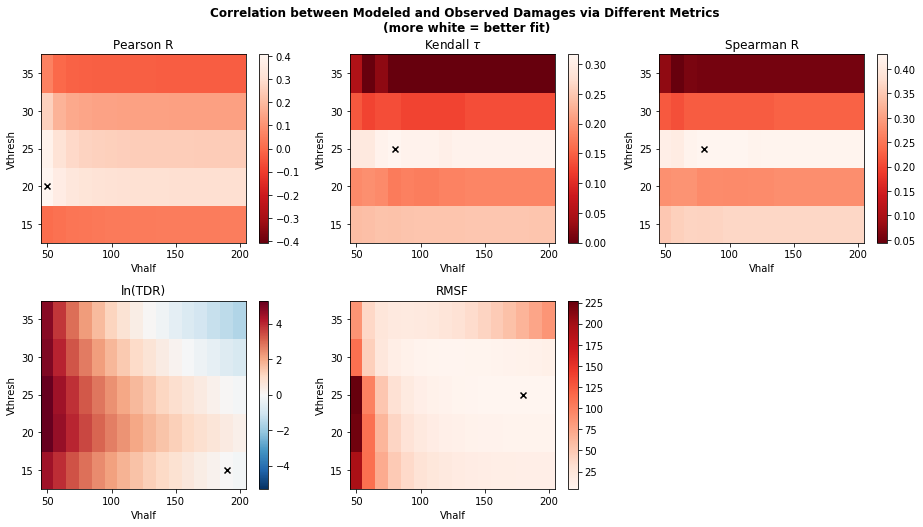

In [46]:
#%%time
# ANALYSIS ACROSS DIFFERENT CORRELATION METRICS
lvt = len(Vthresh)
lvh = len(Vhalf)

region = 'ncr'

# Put all correlation statistics on grid vs Vthresh and Vhalf values for plotting
pr_grid = np.zeros((lvt,lvh))
ktau_grid = np.zeros((lvt,lvh))
sr_grid = np.zeros((lvt,lvh))
tdr_grid = np.zeros((lvt,lvh))
rmsf_grid = np.zeros((lvt,lvh))
for i in np.arange(lvt):
    for j in np.arange(lvh):
        vt = Vthresh[i]
        vh = Vhalf[j]
        label = 'Vhalf-'+str(vh)+'_Vthresh-'+str(vt)
        pr_grid[i,j] = pr[label][region]
        ktau_grid[i,j] = ktau[label][region]
        sr_grid[i,j] = sr[label][region]
        tdr_grid[i,j] = tdr[label][region]
        rmsf_grid[i,j] = rmsf[label][region]

pr_dat = xr.DataArray(pr_grid, coords=[("Vthresh", Vthresh), ("Vhalf", Vhalf)])
ktau_dat = xr.DataArray(ktau_grid, coords=[("Vthresh", Vthresh), ("Vhalf", Vhalf)])
sr_dat = xr.DataArray(sr_grid, coords=[("Vthresh", Vthresh), ("Vhalf", Vhalf)])
tdr_dat = xr.DataArray(tdr_grid, coords=[("Vthresh", Vthresh), ("Vhalf", Vhalf)])
rmsf_dat = xr.DataArray(rmsf_grid, coords=[("Vthresh", Vthresh), ("Vhalf", Vhalf)])


#PLOTTING
plt.figure(figsize=(13, 7))

ax = plt.subplot(231)
pr_dat.plot(cmap = plt.cm.Reds_r)
plt.scatter(pr_dat.Vhalf[np.where(pr_dat== np.max(pr_dat))[1]],pr_dat.Vthresh[np.where(pr_dat== np.max(pr_dat))[0]],color='k',marker='x')
plt.title('Pearson R')

ax = plt.subplot(232)
ktau_dat.plot(cmap = plt.cm.Reds_r)
plt.scatter(ktau_dat.Vhalf[np.where(ktau_dat== np.max(ktau_dat))[1]],ktau_dat.Vthresh[np.where(ktau_dat== np.max(ktau_dat))[0]],color='k',marker='x')
plt.title(r'Kendall $\tau$')

ax = plt.subplot(233)
sr_dat.plot(cmap = plt.cm.Reds_r)
plt.scatter(sr_dat.Vhalf[np.where(sr_dat== np.max(sr_dat))[1]],sr_dat.Vthresh[np.where(sr_dat== np.max(sr_dat))[0]],color='k',marker='x')
plt.title('Spearman R')

ax = plt.subplot(234)
log_tdr = np.log(tdr_dat)
log_tdr.plot()
plt.scatter(log_tdr.Vhalf[np.where(np.abs(log_tdr)== np.min(np.abs(log_tdr)))[1]],log_tdr.Vthresh[np.where(np.abs(log_tdr)== np.min(np.abs(log_tdr)))[0]],color='k',marker='x')
plt.title('ln(TDR)')

ax = plt.subplot(235)
rmsf_dat.plot(cmap = plt.cm.Reds)
plt.scatter(rmsf_dat.Vhalf[np.where(rmsf_dat== np.min(rmsf_dat))[1]],rmsf_dat.Vthresh[np.where(rmsf_dat== np.min(rmsf_dat))[0]],color='k',marker='x')
plt.title('RMSF')

plt.suptitle('Correlation between Modeled and Observed Damages via Different Metrics\n (more white = better fit)', fontweight='bold',y=1.04)
plt.tight_layout()
#plt.savefig('correlations.png')

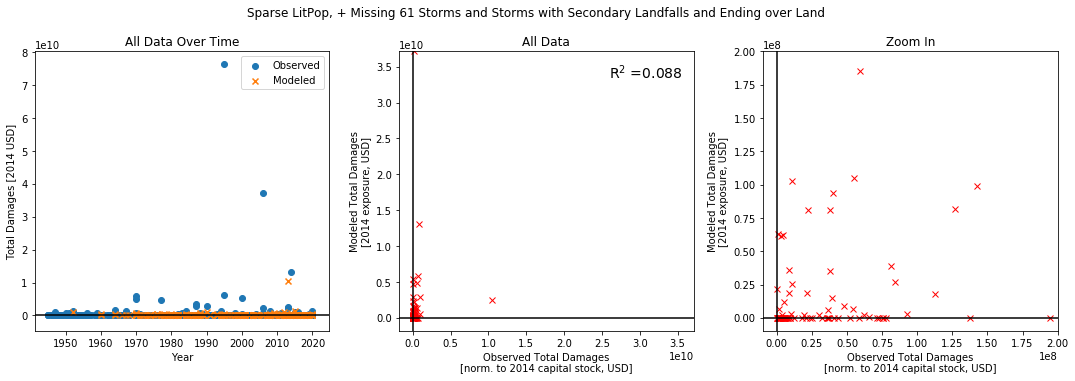

In [192]:
plt.figure(figsize=(15, 5))
# Plot time series of observed vs modeled TC damages
ax = plt.subplot(131)
ax.scatter(year, modeled_damages, label = 'Observed')
ax.scatter(start_year/10000, total_damages_norm, marker='x', label = 'Modeled')
plt.xlabel('Year')
plt.ylabel("Total Damages [2014 USD]")
plt.axhline(0,color='k')
plt.legend()
plt.title('All Data Over Time')
# All data vs plot
plt.subplot(132)
axmax = np.max(np.append(obs_paired_losses, mod_paired_losses))
plt.plot(obs_paired_losses,mod_paired_losses,marker='x',linewidth=0,color='r')
plt.text(axmax*0.7,axmax*0.9,'R$^2$ ='+str(np.round(r_value,4)),fontsize=14)
plt.xlabel('Observed Total Damages\n[norm. to 2014 capital stock, USD]')
plt.ylabel('Modeled Total Damages\n[2014 exposure, USD]')
plt.axvline(0,color='k')
plt.axhline(0,color='k')
plt.xlim([-0.05*axmax,axmax])
plt.ylim([-0.05*axmax,axmax])
plt.title('All Data')
# Zoom in vs plot
plt.subplot(133)
plt.plot(obs_paired_losses,mod_paired_losses,marker='x',linewidth=0,color='r')
plt.xlabel('Observed Total Damages\n[norm. to 2014 capital stock, USD]')
plt.ylabel('Modeled Total Damages\n[2014 exposure, USD]')
plt.xlim([-0.01e9,0.2e9])
plt.ylim([-0.01e9,0.2e9])
plt.axvline(0,color='k')
plt.axhline(0,color='k')
plt.title('Zoom In')
# Modifying whole plot
plt.suptitle(label, y=1.05)
plt.tight_layout()
plt.savefig('assetlosses_'+label+'.png')

# Fit Vhalf by province:

In [39]:
#%%time
# Plot comparing simulated damages to observed damages
Vthresh = np.arange(15,40,5)# Eberenz et al 2020, 25.7 is value used for all and 10 below and above that; m/s
Vhalf = np.arange(50,210,10)# Eberenz et al 2020, value for Philippines using default, RMSF calculation, and TDR calculation; m/s

obs_paired_losses = {}
mod_paired_losses = {}
mod_losses = {}
obs_paired_losses_reg = defaultdict(dict)
mod_paired_losses_reg = defaultdict(dict)
mod_losses_reg = defaultdict(dict)
year_reg = defaultdict(dict)
tdr = defaultdict(dict)
rmsf = defaultdict(dict)

for vt in [25]:#Vthresh:
    for vh in [200]:#Vhalf:
        
        # Calculate modeled damages
        label = 'Vhalf-'+str(vh)+'_Vthresh-'+str(vt)
        file_losses = '/ASSET_LOSSES/VCURVE_SENSITIVITY/'+label+'.nc'
        ds_losses = xr.open_dataset(direc + file_losses)
        mod_losses[label] = ds_losses.sum(dim=['lon','lat']).asset_losses.values

        # Pair observed and modeled damages
        obs_paired_losses[label] = total_damages_norm[matches[:,0]]
        mod_paired_losses[label] = mod_losses[label][matches[:,1]]
        
        # Calculate overall metrics of correlation
        tdr[label]['all'], rmsf[label]['all'] = corr_metrics2(mod_paired_losses[label], obs_paired_losses[label])

        # Select storms that have positive asset losses in NCR 
        # Note: could also just select ones that have positive windspeed, which is what Eberenz does
        est_cost_reg = {}
        for reg in ['NCR']:#state_ids.keys():
            mask0 = d_mask.states.where(d_mask.states==state_ids[reg])
            mask0 = mask0/mask0
            mask = np.repeat(np.expand_dims(mask0,axis=0), np.shape(ds_losses.asset_losses)[0], axis=0)
            mod_losses_inreg = (ds_losses.asset_losses*mask).sum(dim=['lat','lon']).values
            # Indices When Province Affected
            affected_assets = np.where(mod_losses_inreg>0) #indices of positive losses for all data
            affected_assets_match = np.where(mod_losses_inreg[matches[:,1]]>0) # indices of positive losses for only matched data
            # Paired Indices When Province Affected
            mod_paired_losses_reg[label][reg] = mod_paired_losses[label][affected_assets_match]
            obs_paired_losses_reg[label][reg] = obs_paired_losses[label][affected_assets_match]
            mod_losses_reg[label][reg] = mod_losses[label][affected_assets]
            year_reg[label][reg] = year[affected_assets]
        
            # Calculate regional of correlation
            tdr[label][reg], rmsf[label][reg] = corr_metrics2(mod_paired_losses_reg[label][reg], obs_paired_losses_reg[label][reg])
       
#         #PLOTTING
#         plt.figure(figsize=(15, 5))
#         # Plot time series of observed vs modeled TC damages
#         ax = plt.subplot(131)
#         ax.scatter(year, mod_losses[label], label = 'Modeled- all data')
#         ax.scatter(year_reg[label][reg], mod_losses_reg[label][reg], label = 'Modeled-'+reg+' affected', facecolors='none', edgecolors='tab:red')
#         ax.scatter(start_year/10000, total_damages_norm, marker='x', label = 'Observed')
#         plt.xlabel('Year')
#         plt.ylabel("Total Damages [2014 USD]")
#         plt.axhline(0,color='k')
#         plt.legend()
#         plt.title('a) All Data Over Time')
#         # All data vs plot
#         ax = plt.subplot(132)
#         axmax = np.max(np.append(obs_paired_losses[label], mod_paired_losses[label]))
#         ax.scatter(obs_paired_losses[label],mod_paired_losses[label],label='All data')
#         ax.scatter(obs_paired_losses_reg[label][reg],mod_paired_losses_reg[label][reg], facecolors='none', edgecolors='tab:red', label = reg+' affected' )
#         plt.text(axmax*0.15,axmax*0.95,'Pearson R = '+str(np.round(pr[label]['all'],3)),fontsize=12)
#         plt.text(axmax*0.15,axmax*0.9,r'Kendall $\tau$ = '+str(np.round(ktau[label]['all'],3)),fontsize=12)
#         plt.text(axmax*0.15,axmax*0.85,'Spearman R = '+str(np.round(sr[label]['all'],3)),fontsize=12)
#         plt.text(axmax*0.15,axmax*0.8,'TDR = '+str(np.round(tdr[label]['all'],3)),fontsize=12)
#         plt.text(axmax*0.15,axmax*0.75,'RMSF = '+str(np.round(rmsf[label]['all'],3)),fontsize=12)
#         plt.xlabel('Observed Total Damages\n[norm. to 2014 capital stock, USD]')
#         plt.ylabel('Modeled Total Damages\n[2014 exposure, USD]')
#         plt.axvline(0,color='k')
#         plt.axhline(0,color='k')
#         plt.xlim([-0.05*axmax,axmax])
#         plt.ylim([-0.05*axmax,axmax])
#         plt.legend()
#         plt.title('c) All Data')
#         # Zoom in vs plot
#         ax = plt.subplot(133)
#         ax.scatter(obs_paired_losses[label],mod_paired_losses[label],label='All data')
#         ax.scatter(obs_paired_losses_reg[label][reg],mod_paired_losses_reg[label][reg], facecolors='none', edgecolors='tab:red', label = reg+' affected')
#         plt.xlabel('Observed Total Damages\n[norm. to 2014 capital stock, USD]')
#         plt.ylabel('Modeled Total Damages\n[2014 exposure, USD]')
#         plt.xlim([-0.01e9,0.2e9])
#         plt.ylim([-0.01e9,0.2e9])
#         plt.axvline(0,color='k')
#         plt.axhline(0,color='k')
#         plt.legend()
#         plt.title('d) Zoom In')
#         # Modifying whole plot
#         plt.suptitle(label, y=1.03,fontweight='bold')
#         plt.tight_layout()
#         plt.savefig('FIGURES/'+label+'_'+reg+'.png')

pickle.dump( tdr, open( "CORR_METRICS/tdr.p", "wb" ) )
pickle.dump( rmsf, open( "CORR_METRICS/rmsf.p", "wb" ) )


CPU times: user 14.4 s, sys: 35.3 s, total: 49.7 s
Wall time: 1min 29s


# Plot asset losses vs em-dat for province vs 1 vcurve fits

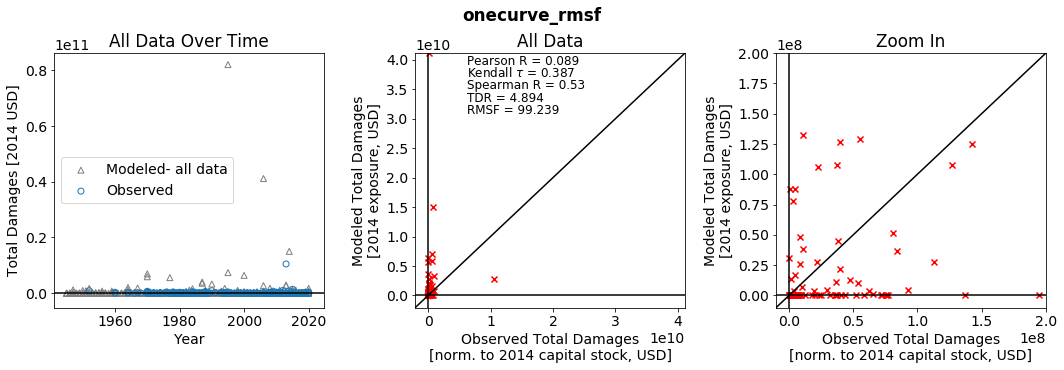

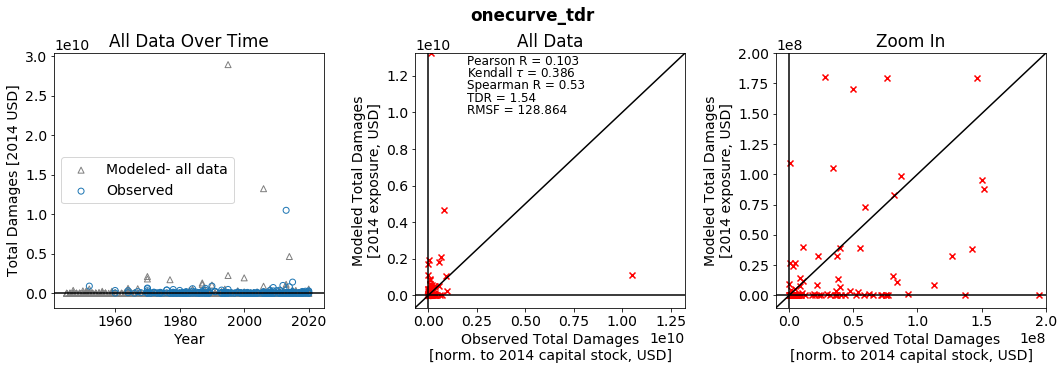

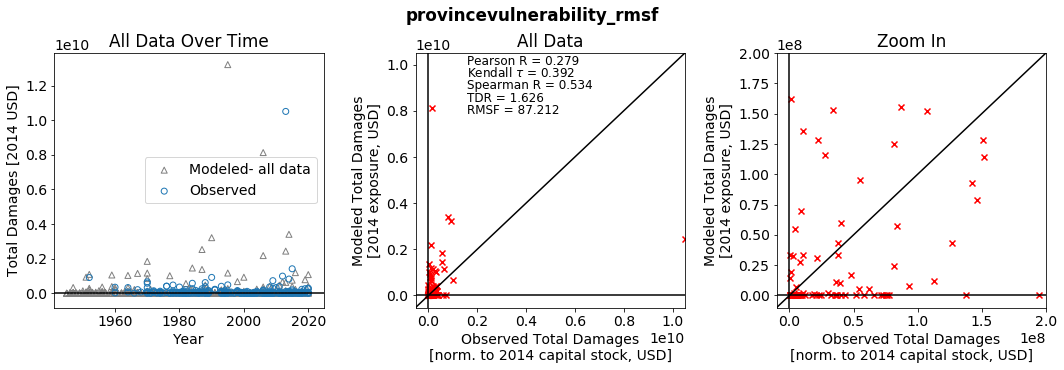

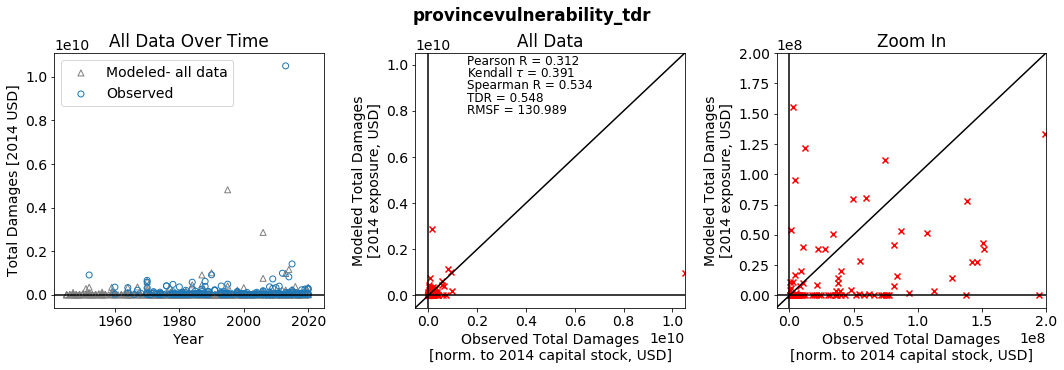

In [90]:
#%%time
# Plot comparing simulated damages to observed damages
plt.rcParams.update({'font.size': 14})

obs_paired_losses = {}
mod_paired_losses = {}
mod_losses = {}
pr = defaultdict(dict)
ktau = defaultdict(dict)
sr = defaultdict(dict)
tdr = defaultdict(dict)
rmsf = defaultdict(dict)
edr = defaultdict(dict)

direc = '/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI/ASSET_LOSSES/'
files = ['onecurve_rmsf','onecurve_tdr','provincevulnerability_rmsf','provincevulnerability_tdr']

for n in range(4):
        
        # Calculate modeled damages
        label = files[n]
        file_losses = label+'.nc'
        ds_losses = xr.open_dataset(direc + file_losses)
        mod_losses[label] = ds_losses.sum(dim=['lon','lat']).asset_losses.values

        # Pair observed and modeled damages
        obs_paired_losses[label] = total_damages_norm[matches[:,0]]
        mod_paired_losses[label] = mod_losses[label][matches[:,1]]
        
        # Calculate overall metrics of correlation
        pr[label]['all'], ktau[label]['all'], sr[label]['all'], tdr[label]['all'], rmsf[label]['all'], edr[label]['all'] = corr_metrics(mod_paired_losses[label], obs_paired_losses[label])
       
        #PLOTTING
        plt.figure(figsize=(15, 5))
        # Plot time series of observed vs modeled TC damages
        ax = plt.subplot(131)
        ax.scatter(year, mod_losses[label], label = 'Modeled- all data',color='grey',marker='^', facecolors='none')
        ax.scatter(start_year/10000, total_damages_norm, label = 'Observed',color='tab:blue',marker='o',facecolors = 'none')
        plt.xlabel('Year')
        plt.ylabel("Total Damages [2014 USD]")
        plt.axhline(0,color='k')
        plt.legend()
        plt.title('All Data Over Time')
        # All data vs plot
        ax = plt.subplot(132)
        axmax = np.max(np.append(obs_paired_losses[label], mod_paired_losses[label]))
        ax.scatter(obs_paired_losses[label],mod_paired_losses[label],color='r',marker='x')
        plt.text(axmax*0.15,axmax*0.95,'Pearson R = '+str(np.round(pr[label]['all'],3)),fontsize=12)
        plt.text(axmax*0.15,axmax*0.9,r'Kendall $\tau$ = '+str(np.round(ktau[label]['all'],3)),fontsize=12)
        plt.text(axmax*0.15,axmax*0.85,'Spearman R = '+str(np.round(sr[label]['all'],3)),fontsize=12)
        plt.text(axmax*0.15,axmax*0.8,'TDR = '+str(np.round(tdr[label]['all'],3)),fontsize=12)
        plt.text(axmax*0.15,axmax*0.75,'RMSF = '+str(np.round(rmsf[label]['all'],3)),fontsize=12)
        plt.xlabel('Observed Total Damages\n[norm. to 2014 capital stock, USD]')
        plt.ylabel('Modeled Total Damages\n[2014 exposure, USD]')
        plt.axvline(0,color='k')
        plt.axhline(0,color='k')
        plt.plot([-1e20,1e20],[-1e20,1e20],color='k')
        plt.xlim([-0.05*axmax,axmax])
        plt.ylim([-0.05*axmax,axmax])
        plt.title('All Data')
        # Zoom in vs plot
        ax = plt.subplot(133)
        ax.scatter(obs_paired_losses[label],mod_paired_losses[label],color='r',marker='x')
        plt.xlabel('Observed Total Damages\n[norm. to 2014 capital stock, USD]')
        plt.ylabel('Modeled Total Damages\n[2014 exposure, USD]')
        plt.plot([-1e20,1e20],[-1e20,1e20],color='k')
        plt.xlim([-0.01e9,0.2e9])
        plt.ylim([-0.01e9,0.2e9])
        plt.axvline(0,color='k')
        plt.axhline(0,color='k')
        plt.title('Zoom In')
        # Modifying whole plot
        plt.suptitle(label, y=1.03,fontweight='bold')
        plt.tight_layout()
        plt.savefig('FIGURES/'+label+'.png',dpi=400)


# Plot impacts in Manila vs not for one vcurve RMSF

ValueError: operands could not be broadcast together with shapes (1551,1123,481) (1551,1551,1123) 

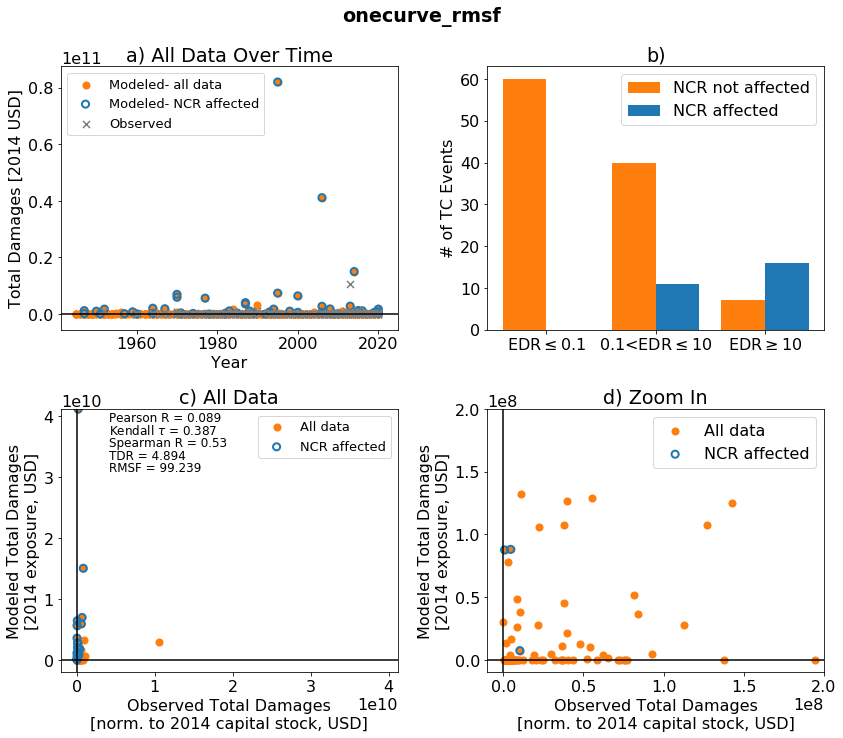

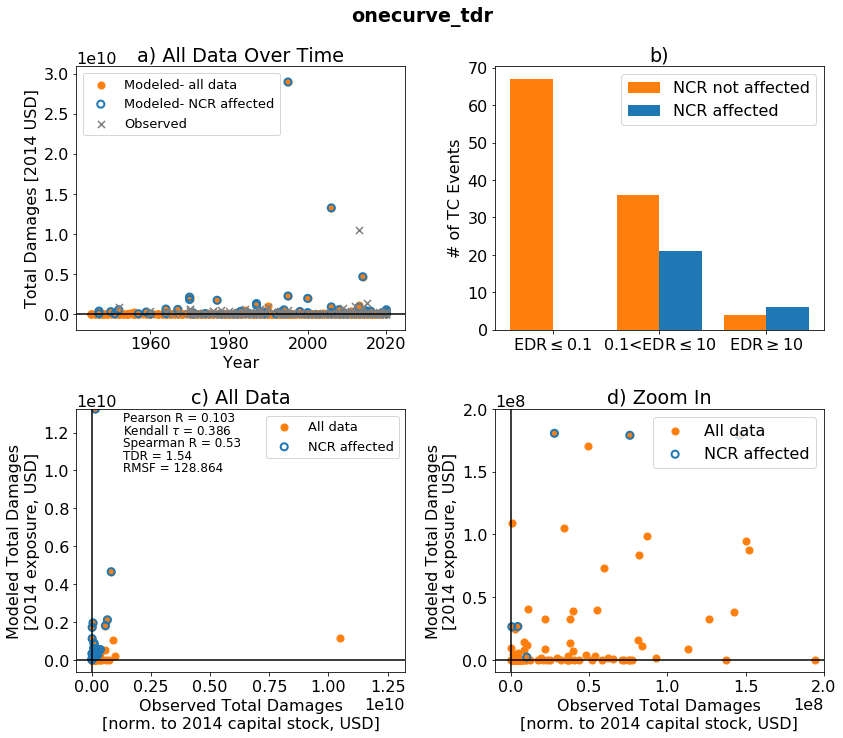

In [43]:
#%%time
# Plot comparing simulated damages to observed damages

obs_paired_losses = {}
mod_paired_losses = {}
modeled_damages = {}
obs_paired_losses_ncr = {}
mod_paired_losses_ncr = {}
modeled_damages_ncr = {}
obs_paired_losses_noncr = {}
mod_paired_losses_noncr = {}
modeled_damages_noncr = {}
est_cost_reg = {}
year_ncr = {}
year_noncr = {}
affected_assets = {}
affected_assets_match = {}
no_affected_assets = {}
no_affected_assets_match = {}
pr = defaultdict(dict)
ktau = defaultdict(dict)
sr = defaultdict(dict)
tdr = defaultdict(dict)
rmsf = defaultdict(dict)
edr = defaultdict(dict)

direc = '/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI/ASSET_LOSSES/'
files = ['onecurve_rmsf','onecurve_tdr']

for n in range(2):
        
        # Calculate modeled damages
        label = files[n]
        file_damages = label+'.nc'
        ds_damages = xr.open_dataset(direc + file_damages)
        modeled_damages[label] = ds_damages.sum(dim=['lon','lat']).asset_losses.values

        # Pair observed and modeled damages
        obs_paired_losses[label] = total_damages_norm[matches[:,0]]
        mod_paired_losses[label] = modeled_damages[label][matches[:,1]]

        # Select storms that have positive asset losses in NCR 
        # Note: could also just select ones that have positive windspeed, which is what Eberenz does
        est_cost_reg = {}
        for key in ['NCR']:
            mask0 = d_mask.states.where(d_mask.states==state_ids[key])
            mask0 = mask0/mask0
            mask = np.repeat(np.expand_dims(mask0,axis=0), np.shape(ds_damages.asset_losses)[0], axis=0)
            est_cost_reg[key] = (ds_damages.asset_losses*mask).sum(dim=['lat','lon']).values
            # Indices
            affected_assets[key] = np.where(est_cost_reg[key]>0) #indices of positive losses for all data
            affected_assets_match[key] = np.where(est_cost_reg[key][matches[:,1]]>0) # indices of positive losses for only matched data
            no_affected_assets[key] = np.where(est_cost_reg[key]==0) #indices of 0 losses for all data
            no_affected_assets_match[key] = np.where(est_cost_reg[key][matches[:,1]]==0) #indices of 0 losses for only matched data
        # Manila Affected
        mod_paired_losses_ncr[label] = mod_paired_losses[label][affected_assets_match[key]]
        obs_paired_losses_ncr[label] = obs_paired_losses[label][affected_assets_match[key]]
        modeled_damages_ncr[label] = modeled_damages[label][affected_assets[key]]
        year_ncr[label] = year[affected_assets[key]]
        # Manila Not Affected
        mod_paired_losses_noncr[label] = mod_paired_losses[label][no_affected_assets_match[key]]
        obs_paired_losses_noncr[label] = obs_paired_losses[label][no_affected_assets_match[key]]
        modeled_damages_noncr[label] = modeled_damages[label][no_affected_assets[key]]
        year_noncr[label] = year[no_affected_assets[key]]
        
        # Calculate metrics of correlation
        # ALL PHI
        pr[label]['all'], ktau[label]['all'], sr[label]['all'], tdr[label]['all'], rmsf[label]['all'], edr[label]['all'] = corr_metrics(mod_paired_losses[label], obs_paired_losses[label])
        # MANILA
        pr[label]['ncr'], ktau[label]['ncr'], sr[label]['ncr'], tdr[label]['ncr'], rmsf[label]['ncr'], edr[label]['ncr'] = corr_metrics(mod_paired_losses_ncr[label], obs_paired_losses_ncr[label])
        # NON-MANILA
        pr[label]['noncr'], ktau[label]['noncr'], sr[label]['noncr'], tdr[label]['noncr'], rmsf[label]['noncr'], edr[label]['noncr'] = corr_metrics(mod_paired_losses_noncr[label], obs_paired_losses_noncr[label])
       
        #PLOTTING
        plt.figure(figsize=(12, 10))
        plt.rcParams.update({'font.size': 16})
        # Plot time series of observed vs modeled TC damages
        ax = plt.subplot(221)
        ms = 50 # markersize
        ax.scatter(year, modeled_damages[label], label = 'Modeled- all data',s=ms,color='tab:orange')
        ax.scatter(year_ncr[label], modeled_damages_ncr[label], label = 'Modeled- NCR affected', facecolors='none', edgecolors='tab:blue',s=ms,linewidth=2)
        ax.scatter(start_year/10000, total_damages_norm, marker='x', label = 'Observed',s=ms,color='grey')
        #ax.set_yscale('log')
        plt.xlabel('Year')
        plt.ylabel("Total Damages [2014 USD]")
        plt.axhline(0,color='k')
        plt.legend(fontsize=13)
        plt.title('a) All Data Over Time')
        # Bar plot of EDR affecting vs not affecting Manila
        ax = plt.subplot(222)
        edr_ncr = edr[label]['all'][np.where(est_cost_reg[key][matches[:,1]]>0)]
        edr_notncr = edr[label]['all'][np.where(est_cost_reg[key][matches[:,1]]==0)]
        x = np.arange(3)
        y1 = [np.sum(edr_notncr<=0.1),np.sum(np.logical_and(edr_notncr>0.1,edr_notncr<=10)), np.sum(edr_notncr>=10)]
        y2 = [np.sum(edr_ncr<=0.1),np.sum(np.logical_and(edr_ncr>0.1,edr_ncr<=10)), np.sum(edr_ncr>=10)]
        ax.bar(x-0.2, y1, width=0.4, color = 'tab:orange', align='center',label = 'NCR not affected')
        ax.bar(x+0.2, y2, width=0.4, color='tab:blue', align='center', label = 'NCR affected')
        plt.ylabel('# of TC Events')
        ax.set_xticks([0,1,2])
        ax.set_xticklabels([r'EDR$\leq0.1$', r'0.1<EDR$\leq10$',r'EDR$\geq10$'])
        plt.legend()
        plt.title('b)')
        # All data vs plot
        ax = plt.subplot(223)
        axmax = np.max(np.append(obs_paired_losses[label], mod_paired_losses[label]))
        ax.scatter(obs_paired_losses[label],mod_paired_losses[label],label='All data',s=ms,color='tab:orange')
        ax.scatter(obs_paired_losses_ncr[label],mod_paired_losses_ncr[label], s=ms,facecolors='none', edgecolors='tab:blue', label = 'NCR affected',linewidth=2 )
        plt.text(axmax*0.1,axmax*0.95,'Pearson R = '+str(np.round(pr[label]['all'],3)),fontsize=12)
        plt.text(axmax*0.1,axmax*0.9,r'Kendall $\tau$ = '+str(np.round(ktau[label]['all'],3)),fontsize=12)
        plt.text(axmax*0.1,axmax*0.85,'Spearman R = '+str(np.round(sr[label]['all'],3)),fontsize=12)
        plt.text(axmax*0.1,axmax*0.8,'TDR = '+str(np.round(tdr[label]['all'],3)),fontsize=12)
        plt.text(axmax*0.1,axmax*0.75,'RMSF = '+str(np.round(rmsf[label]['all'],3)),fontsize=12)
        plt.xlabel('Observed Total Damages\n[norm. to 2014 capital stock, USD]')
        plt.ylabel('Modeled Total Damages\n[2014 exposure, USD]')
        plt.axvline(0,color='k')
        plt.axhline(0,color='k')
        ax.set_xlim([-0.05*axmax,axmax])
        ax.set_ylim([-0.05*axmax,axmax])
        plt.legend(fontsize=13)
        plt.title('c) All Data')
        # Zoom in vs plot
        ax = plt.subplot(224)
        ax.scatter(obs_paired_losses[label],mod_paired_losses[label],label='All data',s=ms,color='tab:orange')
        ax.scatter(obs_paired_losses_ncr[label],mod_paired_losses_ncr[label], s=ms,facecolors='none', edgecolors='tab:blue', linewidth=2, label = 'NCR affected')
        plt.xlabel('Observed Total Damages\n[norm. to 2014 capital stock, USD]')
        plt.ylabel('Modeled Total Damages\n[2014 exposure, USD]')
        ax.set_xlim([-0.01e9,0.2e9])
        ax.set_ylim([-0.01e9,0.2e9])
        plt.axvline(0,color='k')
        plt.axhline(0,color='k')
        plt.legend()
        plt.title('d) Zoom In')
        # Modifying whole plot
        plt.suptitle(label, y=1.03,fontweight='bold')
        plt.tight_layout()
        plt.savefig('FIGURES/'+label+'.png',dpi=400)

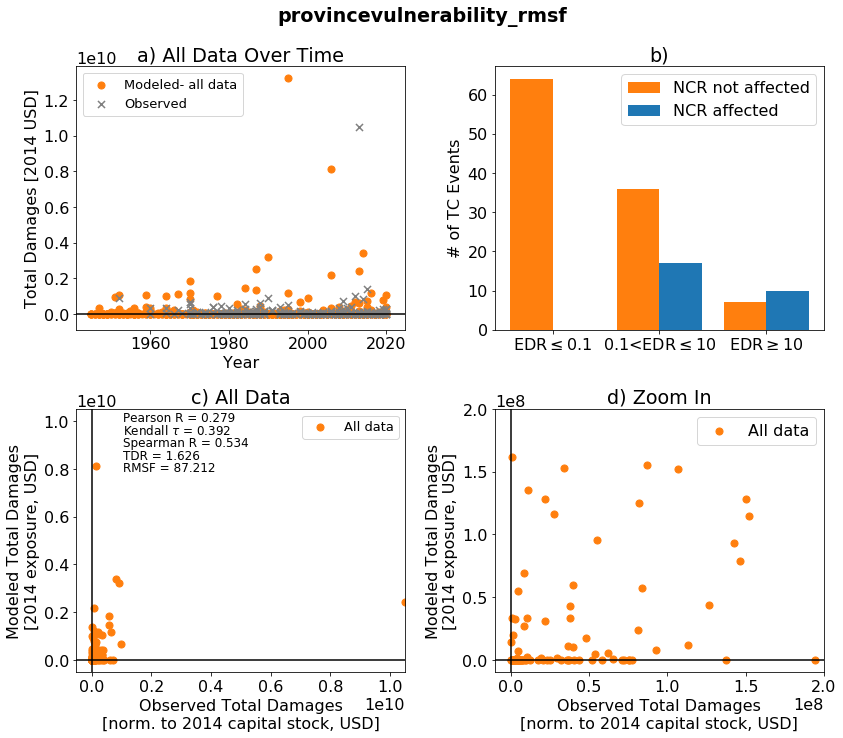

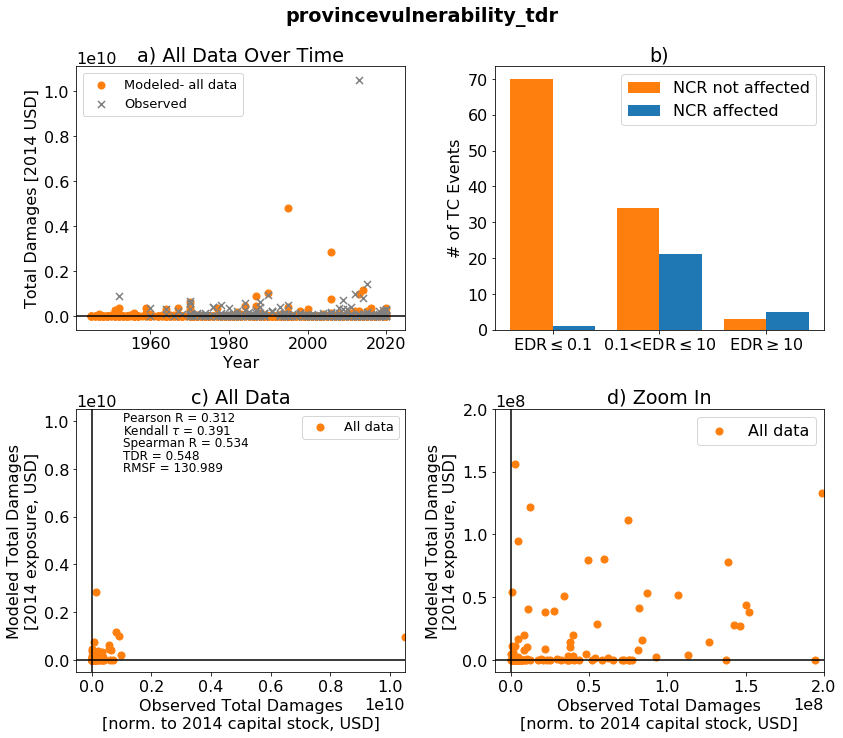

In [49]:
#%%time
# Plot comparing simulated damages to observed damages for Province Vullnerability

obs_paired_losses = {}
mod_paired_losses = {}
modeled_damages = {}
obs_paired_losses_ncr = {}
mod_paired_losses_ncr = {}
modeled_damages_ncr = {}
obs_paired_losses_noncr = {}
mod_paired_losses_noncr = {}
modeled_damages_noncr = {}
est_cost_reg = {}
year_ncr = {}
year_noncr = {}
affected_assets = {}
affected_assets_match = {}
no_affected_assets = {}
no_affected_assets_match = {}
pr = defaultdict(dict)
ktau = defaultdict(dict)
sr = defaultdict(dict)
tdr = defaultdict(dict)
rmsf = defaultdict(dict)
edr = defaultdict(dict)

direc = '/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI/ASSET_LOSSES/'
files = ['provincevulnerability_rmsf','provincevulnerability_tdr']

for n in range(2):
        
        # Calculate modeled damages
        label = files[n]
        file_damages = label+'.nc'
        ds_damages = xr.open_dataset(direc + file_damages)
        modeled_damages[label] = ds_damages.sum(dim=['lon','lat']).asset_losses.values

        # Pair observed and modeled damages
        obs_paired_losses[label] = total_damages_norm[matches[:,0]]
        mod_paired_losses[label] = modeled_damages[label][matches[:,1]]

        # Select storms that have positive asset losses in NCR 
        # Note: could also just select ones that have positive windspeed, which is what Eberenz does
        est_cost_reg = {}
        for key in ['NCR']:
            mask0 = d_mask.states.where(d_mask.states==state_ids[key])
            mask0 = mask0/mask0
            mask = np.repeat(np.expand_dims(mask0,axis=2), np.shape(ds_damages.asset_losses)[2], axis=2)
            est_cost_reg[key] = (ds_damages.asset_losses*mask).sum(dim=['lat','lon']).values
            # Indices
            affected_assets[key] = np.where(est_cost_reg[key]>0) #indices of positive losses for all data
            affected_assets_match[key] = np.where(est_cost_reg[key][matches[:,1]]>0) # indices of positive losses for only matched data
            no_affected_assets[key] = np.where(est_cost_reg[key]==0) #indices of 0 losses for all data
            no_affected_assets_match[key] = np.where(est_cost_reg[key][matches[:,1]]==0) #indices of 0 losses for only matched data
        # Manila Affected
        mod_paired_losses_ncr[label] = mod_paired_losses[label][affected_assets_match[key]]
        obs_paired_losses_ncr[label] = obs_paired_losses[label][affected_assets_match[key]]
        modeled_damages_ncr[label] = modeled_damages[label][affected_assets[key]]
        year_ncr[label] = year[affected_assets[key]]
        # Manila Not Affected
        mod_paired_losses_noncr[label] = mod_paired_losses[label][no_affected_assets_match[key]]
        obs_paired_losses_noncr[label] = obs_paired_losses[label][no_affected_assets_match[key]]
        modeled_damages_noncr[label] = modeled_damages[label][no_affected_assets[key]]
        year_noncr[label] = year[no_affected_assets[key]]
        
        # Calculate metrics of correlation
        # ALL PHI
        pr[label]['all'], ktau[label]['all'], sr[label]['all'], tdr[label]['all'], rmsf[label]['all'], edr[label]['all'] = corr_metrics(mod_paired_losses[label], obs_paired_losses[label])
        # MANILA
        pr[label]['ncr'], ktau[label]['ncr'], sr[label]['ncr'], tdr[label]['ncr'], rmsf[label]['ncr'], edr[label]['ncr'] = corr_metrics(mod_paired_losses_ncr[label], obs_paired_losses_ncr[label])
        # NON-MANILA
        pr[label]['noncr'], ktau[label]['noncr'], sr[label]['noncr'], tdr[label]['noncr'], rmsf[label]['noncr'], edr[label]['noncr'] = corr_metrics(mod_paired_losses_noncr[label], obs_paired_losses_noncr[label])
       
        #PLOTTING
        plt.figure(figsize=(12, 10))
        plt.rcParams.update({'font.size': 16})
        # Plot time series of observed vs modeled TC damages
        ax = plt.subplot(221)
        ms = 50 # markersize
        ax.scatter(year, modeled_damages[label], label = 'Modeled- all data',s=ms,color='tab:orange')
        #ax.scatter(year_ncr[label], modeled_damages_ncr[label], label = 'Modeled- NCR affected', facecolors='none', edgecolors='tab:blue',s=ms,linewidth=2)
        ax.scatter(start_year/10000, total_damages_norm, marker='x', label = 'Observed',s=ms,color='grey')
        #ax.set_yscale('log')
        plt.xlabel('Year')
        plt.ylabel("Total Damages [2014 USD]")
        plt.axhline(0,color='k')
        plt.legend(fontsize=13)
        plt.title('a) All Data Over Time')
        # Bar plot of EDR affecting vs not affecting Manila
        ax = plt.subplot(222)
        edr_ncr = edr[label]['all'][np.where(est_cost_reg[key][matches[:,1]]>0)]
        edr_notncr = edr[label]['all'][np.where(est_cost_reg[key][matches[:,1]]==0)]
        x = np.arange(3)
        y1 = [np.sum(edr_notncr<=0.1),np.sum(np.logical_and(edr_notncr>0.1,edr_notncr<=10)), np.sum(edr_notncr>=10)]
        y2 = [np.sum(edr_ncr<=0.1),np.sum(np.logical_and(edr_ncr>0.1,edr_ncr<=10)), np.sum(edr_ncr>=10)]
        ax.bar(x-0.2, y1, width=0.4, color = 'tab:orange', align='center',label = 'NCR not affected')
        ax.bar(x+0.2, y2, width=0.4, color='tab:blue', align='center', label = 'NCR affected')
        plt.ylabel('# of TC Events')
        ax.set_xticks([0,1,2])
        ax.set_xticklabels([r'EDR$\leq0.1$', r'0.1<EDR$\leq10$',r'EDR$\geq10$'])
        plt.legend()
        plt.title('b)')
        # All data vs plot
        ax = plt.subplot(223)
        axmax = np.max(np.append(obs_paired_losses[label], mod_paired_losses[label]))
        ax.scatter(obs_paired_losses[label],mod_paired_losses[label],label='All data',s=ms,color='tab:orange')
        #ax.scatter(obs_paired_losses_ncr[label],mod_paired_losses_ncr[label], s=ms,facecolors='none', edgecolors='tab:blue', label = 'NCR affected',linewidth=2 )
        plt.text(axmax*0.1,axmax*0.95,'Pearson R = '+str(np.round(pr[label]['all'],3)),fontsize=12)
        plt.text(axmax*0.1,axmax*0.9,r'Kendall $\tau$ = '+str(np.round(ktau[label]['all'],3)),fontsize=12)
        plt.text(axmax*0.1,axmax*0.85,'Spearman R = '+str(np.round(sr[label]['all'],3)),fontsize=12)
        plt.text(axmax*0.1,axmax*0.8,'TDR = '+str(np.round(tdr[label]['all'],3)),fontsize=12)
        plt.text(axmax*0.1,axmax*0.75,'RMSF = '+str(np.round(rmsf[label]['all'],3)),fontsize=12)
        plt.xlabel('Observed Total Damages\n[norm. to 2014 capital stock, USD]')
        plt.ylabel('Modeled Total Damages\n[2014 exposure, USD]')
        plt.axvline(0,color='k')
        plt.axhline(0,color='k')
        ax.set_xlim([-0.05*axmax,axmax])
        ax.set_ylim([-0.05*axmax,axmax])
        plt.legend(fontsize=13)
        plt.title('c) All Data')
        # Zoom in vs plot
        ax = plt.subplot(224)
        ax.scatter(obs_paired_losses[label],mod_paired_losses[label],label='All data',s=ms,color='tab:orange')
        #ax.scatter(obs_paired_losses_ncr[label],mod_paired_losses_ncr[label], s=ms,facecolors='none', edgecolors='tab:blue', linewidth=2, label = 'NCR affected')
        plt.xlabel('Observed Total Damages\n[norm. to 2014 capital stock, USD]')
        plt.ylabel('Modeled Total Damages\n[2014 exposure, USD]')
        ax.set_xlim([-0.01e9,0.2e9])
        ax.set_ylim([-0.01e9,0.2e9])
        plt.axvline(0,color='k')
        plt.axhline(0,color='k')
        plt.legend()
        plt.title('d) Zoom In')
        # Modifying whole plot
        plt.suptitle(label, y=1.03,fontweight='bold')
        plt.tight_layout()
        plt.savefig('FIGURES/'+label+'_noncr.png',dpi=400)

In [ ]:
# Check fit of Vhalf by province

In [52]:
%%time
# Plot comparing simulated damages to observed damages
Vthresh = np.arange(15,40,5)# Eberenz et al 2020, 25.7 is value used for all and 10 below and above that; m/s
Vhalf = np.arange(50,210,10)# Eberenz et al 2020, value for Philippines using default, RMSF calculation, and TDR calculation; m/s

obs_paired_losses = {}
mod_paired_losses = {}
mod_losses = {}
obs_paired_losses_reg = defaultdict(dict)
mod_paired_losses_reg = defaultdict(dict)
mod_losses_reg = defaultdict(dict)
year_reg = defaultdict(dict)
tdr = defaultdict(dict)
rmsf = defaultdict(dict)

direc = '/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI/ASSET_LOSSES/'
files = ['provincevulnerability_rmsf']# ['onecurve_rmsf'],'provincevulnerability_tdr']

for n in range(1):
        
        # Calculate modeled damages
        label = files[n]
        file_losses = label+'.nc'
        ds_losses = xr.open_dataset(direc + file_losses)
        mod_losses[label] = ds_losses.sum(dim=['lon','lat']).asset_losses.values

        # Pair observed and modeled damages
        obs_paired_losses[label] = total_damages_norm[matches[:,0]]
        mod_paired_losses[label] = mod_losses[label][matches[:,1]]
        
        # Calculate overall metrics of correlation
        tdr[label]['all'], rmsf[label]['all'] = corr_metrics2(mod_paired_losses[label], obs_paired_losses[label])

        # Select storms that have positive asset losses in NCR 
        # Note: could also just select ones that have positive windspeed, which is what Eberenz does
        est_cost_reg = {}
        for reg in state_ids.keys():
            mask0 = d_mask.states.where(d_mask.states==state_ids[reg])
            mask0 = mask0/mask0
            #mask = np.repeat(np.expand_dims(mask0,axis=0), np.shape(ds_losses.asset_losses)[0], axis=0)
            mask = np.repeat(np.expand_dims(mask0,axis=2), np.shape(ds_losses.asset_losses)[2], axis=2)
            mod_losses_inreg = (ds_losses.asset_losses*mask).sum(dim=['lat','lon']).values
            # Indices When Province Affected
            affected_assets = np.where(mod_losses_inreg>0) #indices of positive losses for all data
            affected_assets_match = np.where(mod_losses_inreg[matches[:,1]]>0) # indices of positive losses for only matched data
            # Paired Indices When Province Affected
            mod_paired_losses_reg[label][reg] = mod_paired_losses[label][affected_assets_match]
            obs_paired_losses_reg[label][reg] = obs_paired_losses[label][affected_assets_match]
            mod_losses_reg[label][reg] = mod_losses[label][affected_assets]
            year_reg[label][reg] = year[affected_assets]
        
            # Calculate regional of correlation
            tdr[label][reg], rmsf[label][reg] = corr_metrics2(mod_paired_losses_reg[label][reg], obs_paired_losses_reg[label][reg])
            
pickle.dump( tdr, open( "CORR_METRICS/tdr_check_province.p", "wb" ) )
pickle.dump( rmsf, open( "CORR_METRICS/rmsf_check_province.p", "wb" ) )

/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 2min 17s, sys: 2min 46s, total: 5min 4s
Wall time: 5min 3s


In [167]:
# To check the matching work looked at Rammasun (Glenda)
# Modeled index = 432, damages 1.3e10
# Obs index = 221, damages 8.2e8
# Found in paired losses: [8.20576000e+08, 1.30901863e+10],

Text(0, 0.5, 'IBTrACS Start Date')

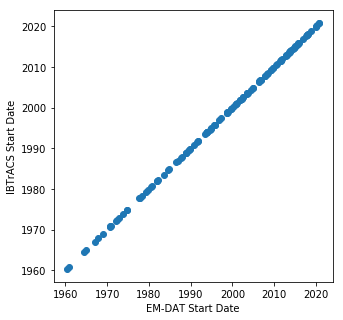

In [527]:
plt.figure(figsize=(5, 5))
plt.scatter(start_date[matches[:,0]],tc_start_date[matches[:,1]])
plt.xlabel('EM-DAT Start Date')
plt.ylabel('IBTrACS Start Date')

In [ ]:
# Try normalizing by particular year GDP